# Comparing the Old and New Lists
 - points per year for fishing vessels
 - number of vessels with more than and fewer than 1000 positions
 - number of vessels on "new" lists versus old lists
 - how changing the cutoff of an "active" vessel affects the total amount of fishing

In [68]:
import csv
import bq
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import matplotlib
import os

In [69]:
client = bq.Client.Get()

def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer

years = [2012,2013,2014,2015,2016]

In [70]:

pos_array = []

for y in years:
    y = str(y)
    startdate = y+'-01-01'
    enddate = y+'-12-31'

    q = '''
    select integer(positions/100)*100 positions_bin,
    count(*)
    from
    (SELECT
      a.mmsi AS mmsi,
      a.fishing_msg_ratio AS fishing_msg_ratio,
      b.c_pos as positions
    FROM (
      SELECT
        mmsi,
        COUNT(*) c_msg,
        sum (shiptype_text = 'Fishing') c_fishing,
        sum (shiptype_text = 'Fishing') / COUNT(*) fishing_msg_ratio
      FROM (TABLE_DATE_RANGE([pipeline_740__classify.], TIMESTAMP('{startdate}'), TIMESTAMP('{enddate}')))
      WHERE
        type IN (5,
          24)
        AND shiptype_text IS NOT NULL
        AND shiptype_text != 'Not available'
      GROUP EACH BY
        mmsi
      HAVING
        c_fishing > 10
        AND fishing_msg_ratio > .99 ) a
    JOIN EACH (
      SELECT
        INTEGER(mmsi) AS mmsi,
        COUNT(*) AS c_pos
      FROM (TABLE_DATE_RANGE([pipeline_740__classify.], TIMESTAMP('{startdate}'), TIMESTAMP('{enddate}')))
      WHERE
        lat IS NOT NULL
        AND lon IS NOT NULL
      GROUP BY
        mmsi
      HAVING
        c_pos > 100 )b
    ON
      a.mmsi = b.mmsi) group by positions_bin
      order by positions_bin asc
    '''.format(startdate=startdate, enddate=enddate)

    pos = Query(q)
    
    vs = np.array([int(p[1]) for p in pos])
    ps = np.array([int(p[0]) for p in pos])
    pos_array.append([ps,vs])

Waiting on bqjob_r16f6377d5d51195c_0000015928b13f83_16 ... (0s) Current status: DONE   
Query time: 4.29994702339 seconds.
Waiting on bqjob_r6262a66228eb6ea9_0000015928b15050_17 ... (0s) Current status: DONE   
Query time: 4.29145598412 seconds.
Waiting on bqjob_r36548e19120b9ab5_0000015928b16116_18 ... (0s) Current status: DONE   
Query time: 4.45581698418 seconds.
Waiting on bqjob_r6d3745745e535936_0000015928b17280_19 ... (0s) Current status: DONE   
Query time: 5.24252605438 seconds.
Waiting on bqjob_r6af02e9adafedc42_0000015928b186fc_20 ... (0s) Current status: DONE   
Query time: 3.8270471096 seconds.


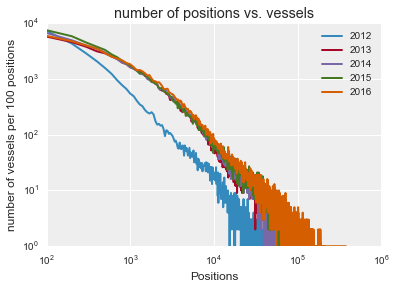

In [71]:
for pos, y in zip(pos_array, years):
    plt.loglog(pos[0],pos[1], label=str(y))
plt.ylabel("number of vessels per 100 positions")
plt.xlabel("Positions")
plt.title("number of positions vs. vessels")
plt.legend()
plt.show()

In [72]:
lessthan = []
greaterhthan = []
for pos in pos_array:
    a = 0 # less than 1000
    b = 0 # more than 1000
    for p,v in zip(pos[0],pos[1]):
        if p<1000:
            a+=v
        else:
            b+=v
    greaterhthan.append(b)
    lessthan.append(a)
data = [[l,g] for l, g in zip(lessthan,greaterhthan)]
data
df = pd.DataFrame(data,index=[2012,2013,2014,2015,2016],columns=['<1000','>1000'])

In [73]:
df.head()

,<1000,>1000
2012,21593,8801
2013,28560,36255
2014,30481,37749
2015,33940,39709
2016,29799,46554


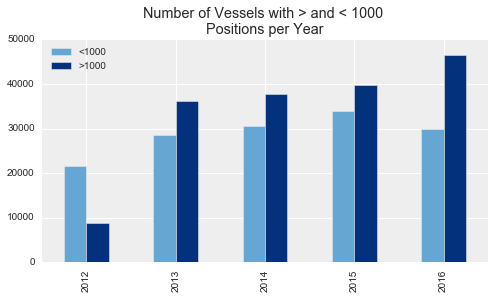

In [74]:
matplotlib.style.use('bmh')
plt.rcParams["figure.figsize"] = [8,4]

df.plot.bar(color=['#66A6D2','#04317C'])   
plt.title("Number of Vessels with > and < 1000 \nPositions per Year")

In [75]:
counts = []
for year in range(2012,2017):
    q = '''
    select count(*) from [scratch_david_mmsi_lists.500_cutoff_{}]'''.format(year)
    p = int(Query(q)[0][0])
    counts.append(p)

Waiting on bqjob_r69159fca029fd028_0000015928b19976_21 ... (0s) Current status: DONE   
Query time: 1.13290405273 seconds.
Waiting on bqjob_r7e8a8c9732fd6fad_0000015928b19de3_22 ... (0s) Current status: DONE   
Query time: 1.49351215363 seconds.
Waiting on bqjob_r3b4b8f8146722b13_0000015928b1a3b9_23 ... (0s) Current status: DONE   
Query time: 1.19010400772 seconds.
Waiting on bqjob_r78fa2826f46ecb3b_0000015928b1a860_24 ... (0s) Current status: DONE   
Query time: 1.03754091263 seconds.
Waiting on bqjob_r4ff52e61e9ade72a_0000015928b1ac6e_25 ... (0s) Current status: DONE   
Query time: 1.23402285576 seconds.


In [76]:
df2 = df.copy()
df2["Old Lists"] = df[">1000"]
df2["New Lists"] = counts

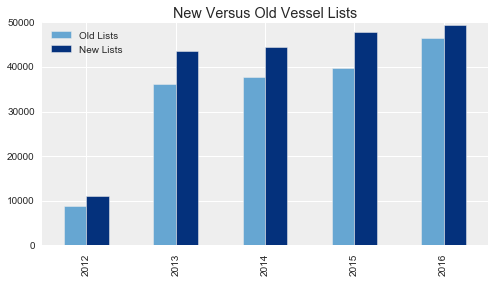

In [77]:
df2[['Old Lists','New Lists']].plot.bar(color=['#66A6D2','#04317C'])   
plt.title("New Versus Old Vessel Lists")

# As we eliminate vessels with fewer than a given number of active points, how much of the fishing hours do we eiliminate?

Waiting on bqjob_r60e6a1c0a49425b4_0000015928b1b2a0_26 ... (23s) Current status: DONE   
Query time: 26.0461280346 seconds.


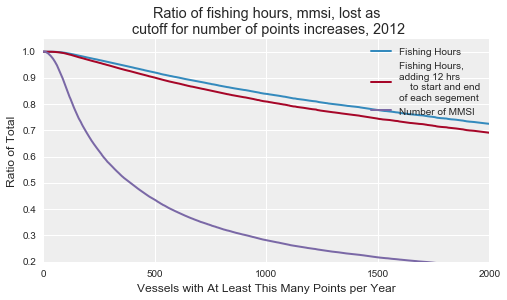

Waiting on bqjob_r18b4c954171d376d_0000015928b2198f_27 ... (23s) Current status: DONE   
Query time: 26.7486999035 seconds.


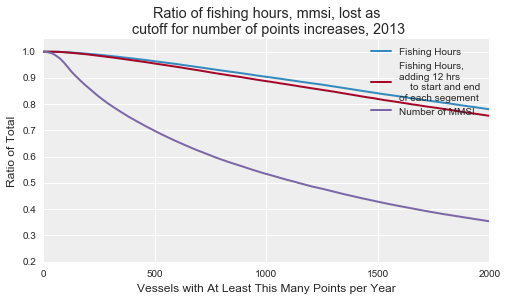

Waiting on bqjob_r799a5531917993ae_0000015928b28381_28 ... (23s) Current status: DONE   
Query time: 27.1703960896 seconds.


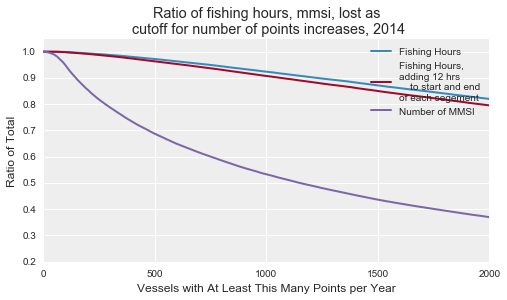

Waiting on bqjob_r139727d6c10e82f2_0000015928b2ef43_29 ... (23s) Current status: DONE   
Query time: 27.5762300491 seconds.


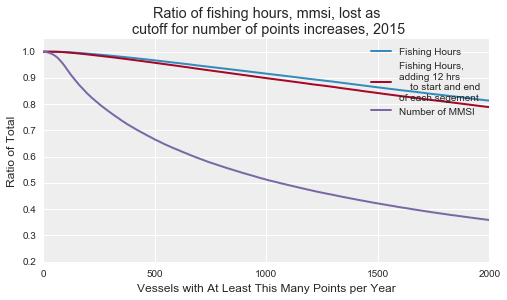

Waiting on bqjob_r4a50b1e314e2cb8c_0000015928b35cd8_30 ... (23s) Current status: DONE   
Query time: 26.1282150745 seconds.


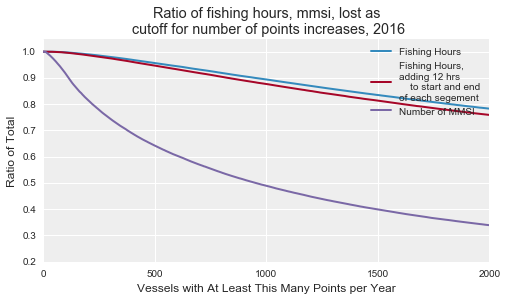

In [78]:
# see how fishing hours vary with number of points

tot_points_ = []
num_mmsi_ = []
fishing_hours_adjusted_ = []
fishing_hours_ = []
for y in years:
    q = '''

    SELECT
      sum(a.fishing_hours) fishing_hours,
      sum(a.fishing_hours_adjusted) fishing_hours_adjusted,
      exact_count_distinct(a.mmsi) num_mmsi,
      b.tot_points tot_points,
    FROM (
      SELECT
        mmsi,
        SUM(fishing_hours) fishing_hours,
        SUM(fishing_hours_adjusted) fishing_hours_adjusted
      FROM
        [scratch_david.{y}_mmsi_summaries_v2]
      WHERE
        mmsi IN (
        SELECT
          mmsi
        FROM
          scratch_david_mmsi_lists.likely_fishing_{y})
      GROUP BY
        mmsi ) a
    LEFT JOIN (
      SELECT
        mmsi,
        SUM(points) tot_points,
        SUM(active_points) tot_active_points,
        SUM(IF(active_points>=5,1,0)) active_days5,
        SUM(IF(active_points>=10,1,0)) active_days10,
        SUM(IF(active_points>=15,1,0)) active_days15,
        SUM(IF(active_points>=20,1,0)) active_days20,
      FROM
        [scratch_david.{y}_mmsi_summaries_v2]
        group by mmsi) b
    ON
      a.mmsi = b.mmsi
    group by tot_points
    order by tot_points asc
    '''.format(y=y)
    fp = Query(q)

    fishing_hours = np.array([float(f[0]) for f in fp])
    fishing_hours = np.array([fishing_hours[i:].sum() for i in range(len(fp))])
    fishing_hours_adjusted = np.array([float(f[1]) for f in fp])
    fishing_hours_adjusted = np.array([fishing_hours_adjusted[i:].sum() for i in range(len(fp))])
    num_mmsi  = np.array([int(f[2]) for f in fp])
    num_mmsi = np.array([num_mmsi[i:].sum() for i in range(len(fp))])
    tot_points = np.array([int(f[3]) for f in fp])
    plt.plot(tot_points,fishing_hours/fishing_hours[0], label = "Fishing Hours")
    plt.plot(tot_points,fishing_hours_adjusted/fishing_hours_adjusted[0], label = "Fishing Hours, \nadding 12 hrs\n\
    to start and end\nof each segement")
    plt.xlim(0,1000)

    # plt.scatter(tot_points,fishing_hours)
    plt.plot(tot_points,num_mmsi/float(num_mmsi[0]), label="Number of MMSI")
    plt.xlim(0,2000)
    plt.ylim(.2,1.05)
    plt.title("Ratio of fishing hours, mmsi, lost as\n cutoff for number of points increases, {}".format(y))
    plt.xlabel("Vessels with At Least This Many Points per Year")
    plt.ylabel("Ratio of Total")
    plt.legend()
    plt.show()
    
    
    tot_points_.append(tot_points)
    num_mmsi_.append(num_mmsi)
    fishing_hours_adjusted_.append(fishing_hours_adjusted)
    fishing_hours_.append(fishing_hours)

Waiting on bqjob_r75081c982bfe6768_0000015928b3c4b5_31 ... (23s) Current status: DONE   
Query time: 25.8889439106 seconds.


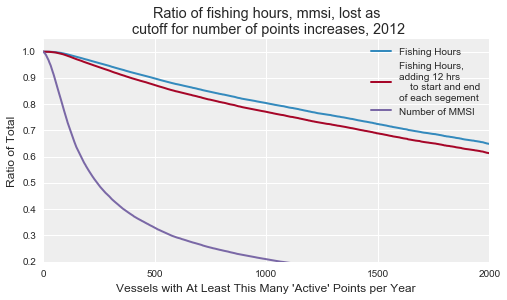

Waiting on bqjob_r69763028910d90ef_0000015928b42ad4_32 ... (15s) Current status: DONE   
Query time: 18.29271698 seconds.


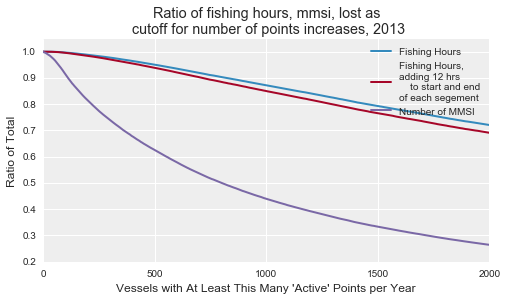

Waiting on bqjob_r13db5ff9bf1a9a10_0000015928b473c1_33 ... (23s) Current status: DONE   
Query time: 26.2971549034 seconds.


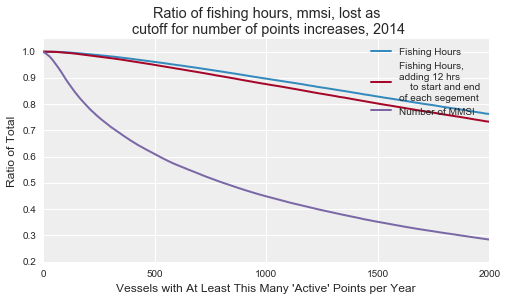

Waiting on bqjob_r67e2e8648dc1b88d_0000015928b4dbd7_34 ... (23s) Current status: DONE   
Query time: 27.3416719437 seconds.


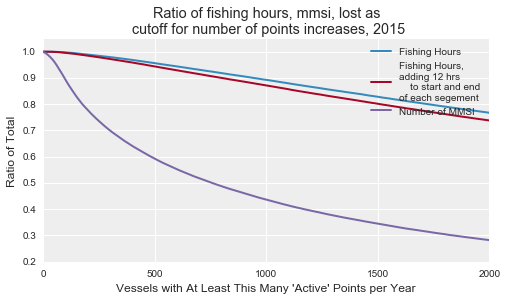

Waiting on bqjob_r56099a857e1bb109_0000015928b54815_35 ... (23s) Current status: DONE   
Query time: 26.1375370026 seconds.


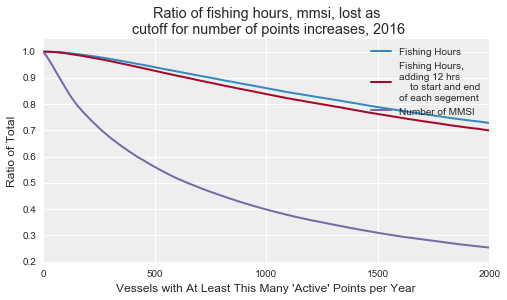

In [79]:
# see how fishing hours vary with number of points

tot_points_active = []
num_mmsi_active = []
fishing_hours_adjusted_active = []
fishing_hours_active = []
for y in years:
    q = '''

    SELECT
      sum(a.fishing_hours) fishing_hours,
      sum(a.fishing_hours_adjusted) fishing_hours_adjusted,
      exact_count_distinct(a.mmsi) num_mmsi,
      b.tot_active_points tot_active_points,
    FROM (
      SELECT
        mmsi,
        SUM(fishing_hours) fishing_hours,
        SUM(fishing_hours_adjusted) fishing_hours_adjusted
      FROM
        [scratch_david.{y}_mmsi_summaries_v2]
      WHERE
        mmsi IN (
        SELECT
          mmsi
        FROM
          scratch_david_mmsi_lists.likely_fishing_{y})
      GROUP BY
        mmsi ) a
    LEFT JOIN (
      SELECT
        mmsi,
        SUM(points) tot_points,
        SUM(active_points) tot_active_points,
        SUM(IF(active_points>=5,1,0)) active_days5,
        SUM(IF(active_points>=10,1,0)) active_days10,
        SUM(IF(active_points>=15,1,0)) active_days15,
        SUM(IF(active_points>=20,1,0)) active_days20,
      FROM
        [scratch_david.{y}_mmsi_summaries_v2]
        group by mmsi) b
    ON
      a.mmsi = b.mmsi
    group by tot_active_points
    order by tot_active_points
    '''.format(y=y)
    fp = Query(q)

    fishing_hours = np.array([float(f[0]) for f in fp])
    fishing_hours = np.array([fishing_hours[i:].sum() for i in range(len(fp))])
    fishing_hours_adjusted = np.array([float(f[1]) for f in fp])
    fishing_hours_adjusted = np.array([fishing_hours_adjusted[i:].sum() for i in range(len(fp))])
    num_mmsi  = np.array([int(f[2]) for f in fp])
    num_mmsi = np.array([num_mmsi[i:].sum() for i in range(len(fp))])
    tot_points = np.array([int(f[3]) for f in fp])
    plt.plot(tot_points,fishing_hours/fishing_hours[0], label = "Fishing Hours")
    plt.plot(tot_points,fishing_hours_adjusted/fishing_hours_adjusted[0], label = "Fishing Hours, \nadding 12 hrs\n\
    to start and end\nof each segement")
    plt.xlim(0,1000)
    plt.ylim(.2,1.05)

    # plt.scatter(tot_points,fishing_hours)
    plt.plot(tot_points,num_mmsi/float(num_mmsi[0]), label="Number of MMSI")
    plt.xlim(0,2000)
    plt.title("Ratio of fishing hours, mmsi, lost as\n cutoff for number of points increases, {}".format(y))
    plt.xlabel("Vessels with At Least This Many 'Active' Points per Year")
    plt.ylabel("Ratio of Total")
    plt.legend()
    plt.show()
    
    
    tot_points_active.append(tot_points)
    num_mmsi_active.append(num_mmsi)
    fishing_hours_adjusted_active.append(fishing_hours_adjusted)
    fishing_hours_active.append(fishing_hours)